1. setup

Importera in bibliotek
Sätt k-värde 
Sät top_n-värde

In [233]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

Nedan lägger vi till csv-filerna med Användares betyg och spelen 
....

In [236]:
df_ratings = pd.read_csv("dataset/user_ratings.csv")
df_games = pd.read_csv("dataset/games.csv")
df = pd.merge(df_ratings, df_games[['BGGId', 'Name']], 
              on='BGGId', how='left')

In [237]:
df

,BGGId,Rating,Username,Name
0,213788,8.0,Tonydorrf,Ascension: Year Three Collector's Edition
1,213788,8.0,tachyon14k,Ascension: Year Three Collector's Edition
2,213788,8.0,Ungotter,Ascension: Year Three Collector's Edition
3,213788,8.0,brainlocki3,Ascension: Year Three Collector's Edition
4,213788,8.0,PPMP,Ascension: Year Three Collector's Edition
...,...,...,...,...
18942210,165521,3.0,rseater,Rory's Story Cubes: Medic
18942211,165521,3.0,Bluefox86,Rory's Story Cubes: Medic
18942212,165521,3.0,serginator,Rory's Story Cubes: Medic
18942213,193488,1.0,CaptainCattan,Airlines


2 Preprocessing

Handle missing valuee

In [238]:
null_counts = df.isnull().sum()
print(null_counts)

BGGId        0
Rating       0
Username    63
Name         0
dtype: int64


In [208]:
df = df.dropna()

In [209]:
df

,BGGId,Rating,Username,Name
0,213788,8.0,Tonydorrf,Ascension: Year Three Collector's Edition
1,213788,8.0,tachyon14k,Ascension: Year Three Collector's Edition
2,213788,8.0,Ungotter,Ascension: Year Three Collector's Edition
3,213788,8.0,brainlocki3,Ascension: Year Three Collector's Edition
4,213788,8.0,PPMP,Ascension: Year Three Collector's Edition
...,...,...,...,...
18942210,165521,3.0,rseater,Rory's Story Cubes: Medic
18942211,165521,3.0,Bluefox86,Rory's Story Cubes: Medic
18942212,165521,3.0,serginator,Rory's Story Cubes: Medic
18942213,193488,1.0,CaptainCattan,Airlines


In [210]:
#Check if any rows are duplicates
duplicates = df.duplicated().value_counts()
print(duplicates)

False    18942152
dtype: int64


Remove duplicate ratings for the same game by the same user (due to different version of the game etc)

In [211]:
# Merge the mean ratings back to the original DataFrame based on 'Username' and 'Name'
# Filter the DataFrame to keep only the original rows (non-duplicates) and the calculated mean ratings
# Drop the original 'Rating' column and rename the mean rating column
# Reindex the columns to move 'Rating' to the second position
mean_ratings = df.groupby(['Username', 'BGGId'])['Rating'].mean()
df_removed_duplicates = df.merge(mean_ratings, 
            on=['Username', 'BGGId'], suffixes=('', '_mean'))
df_unique = df_removed_duplicates[~df_removed_duplicates.
            duplicated(subset=['Username', 'BGGId'], keep=False)]
df_dropped = df_unique.drop(columns=['Rating']).rename(columns=
            {'Rating_mean': 'Rating'})
column_order = ['BGGId', 'Rating', 'Username', 'Name']
df_dropped = df_dropped.reindex(columns=column_order)


Calculate average rating for users and add average rating and adjusted rating column

In [212]:
# Step 1: Group by 'Username' and calculate the average rating for each user
# Step 2: Merge the average ratings back into the original DataFrame
# Step 3: Subtract the average rating from each rating to get the adjusted rating
# Now df contains the adjusted ratings in the 'Adjusted_Rating' column
user_avg_ratings = df_dropped.groupby(
    'Username')['Rating'].mean().reset_index()
df_adjusted_mean = pd.merge(df_dropped, user_avg_ratings, 
                            on='Username', suffixes=('', '_avg'))
df_adjusted_mean['Adjusted_Rating'] = df_adjusted_mean[
    'Rating'] - df_adjusted_mean['Rating_avg']
column_order = ['BGGId', 'Rating', 'Rating_avg', 
                'Adjusted_Rating', 'Username', 'Name']
df_adjusted_mean = df_adjusted_mean.reindex(columns=column_order)

In [213]:
df_adjusted_mean

,BGGId,Rating,Rating_avg,Adjusted_Rating,Username,Name
0,213788,8.0,7.367589,0.632411,Tonydorrf,Ascension: Year Three Collector's Edition
1,206593,8.0,7.367589,0.632411,Tonydorrf,Stronghold: Undead (Second Edition) – Kickstar...
2,267333,7.0,7.367589,-0.367589,Tonydorrf,Goetia: Nine Kings of Solomon
3,249824,6.0,7.367589,-1.367589,Tonydorrf,Munchkin Harry Potter Deluxe
4,301085,6.0,7.367589,-1.367589,Tonydorrf,Rebis
...,...,...,...,...,...,...
18878027,195742,5.0,5.000000,0.000000,codyk4545,The Godfather: A New Don
18878028,215065,2.0,2.000000,0.000000,UnrealTravis,75 Gnom' Street
18878029,127096,3.0,3.000000,0.000000,Elianto1989,Metal Adventures
18878030,126471,2.0,2.000000,0.000000,DaLanimilbus,Nowhere to Go


Filter dataset

In [214]:
# Group by 'Username' and count the number of rows for each group
grouped_user_counts = df_adjusted_mean.groupby('Username').size()
grouped_user_counts

Username
 Fu_Koios              2
 beastvol              9
 mycroft              14
 woh                   5
(mostly) harmless      1
                    ... 
zzzuzu                39
zzzvone               21
zzzxxxyyy             32
zzzzzane             154
Æleksandr Þræð        12
Length: 411312, dtype: int64

In [215]:
# Group by 'BGGId' and count the number of rows for each group
grouped_counts = df_adjusted_mean.groupby('BGGId').size()
grouped_counts

BGGId
1          5295
2           560
3         15077
4           342
5         18152
          ...  
347146       42
347521       71
348955       67
349131       66
349161        7
Length: 21925, dtype: int64

In [216]:
game_ratings = 3000
rating_counter = df_adjusted_mean['BGGId'].value_counts()
filtered_out = rating_counter[rating_counter < game_ratings].index
games_mask = df_adjusted_mean['BGGId'].isin(filtered_out)
df_adjusted_mean.drop(index=df_adjusted_mean[games_mask].index, 
                      inplace=True)

In [217]:
df_adjusted_mean

,BGGId,Rating,Rating_avg,Adjusted_Rating,Username,Name
44,36218,7.0,7.367589,-0.367589,Tonydorrf,Dominion
45,133473,6.0,7.367589,-1.367589,Tonydorrf,Sushi Go!
46,167791,9.0,7.367589,1.632411,Tonydorrf,Terraforming Mars
47,230802,8.0,7.367589,0.632411,Tonydorrf,Azul
48,174430,9.0,7.367589,1.632411,Tonydorrf,Gloomhaven
...,...,...,...,...,...,...
18852015,125548,10.0,10.000000,0.000000,brocespringsteen,Pixel Tactics
18852016,125548,10.0,10.000000,0.000000,Czerstwy,Pixel Tactics
18852018,125548,10.0,10.000000,0.000000,Shining Creations,Pixel Tactics
18852019,125548,10.0,10.000000,0.000000,MissTaluva,Pixel Tactics


In [218]:
user_ratings = 100
rating_counter = df_adjusted_mean['Username'].value_counts()
filtered_out = rating_counter[rating_counter < user_ratings].index
user_mask = df_adjusted_mean['Username'].isin(filtered_out)
df_adjusted_mean.drop(index=df_adjusted_mean[user_mask].index, 
                      inplace=True)

In [219]:
df_adjusted_mean

,BGGId,Rating,Rating_avg,Adjusted_Rating,Username,Name
386,178900,7.0,7.641304,-0.641304,PPMP,Codenames
387,14996,7.0,7.641304,-0.641304,PPMP,Ticket to Ride: Europe
388,40692,7.0,7.641304,-0.641304,PPMP,Small World
389,822,8.0,7.641304,0.358696,PPMP,Carcassonne
390,70323,7.0,7.641304,-0.641304,PPMP,King of Tokyo
...,...,...,...,...,...,...
18691910,634,10.0,10.000000,0.000000,AbsterPro,River Dragons
18691911,174973,10.0,10.000000,0.000000,AbsterPro,Boss Monster 2: The Next Level
18691912,191894,10.0,10.000000,0.000000,AbsterPro,Imagine
18691913,19526,10.0,10.000000,0.000000,AbsterPro,Elasund: The First City


In [220]:
# Group by 'Username' and count the number of rows for each group
grouped_user_counts = df_adjusted_mean.groupby('Username').size()
grouped_user_counts

Username
-=Yod@=-     201
-Johnny-     245
-mIDE-       356
-toni-       137
...Hammer    123
            ... 
zzyzxuk      118
zzzabiss     296
zzzhsm       171
zzzoren      141
zzzzzane     136
Length: 31482, dtype: int64

In [221]:
# Group by 'BGGId' and count the number of rows for each group
grouped_counts = df_adjusted_mean.groupby('BGGId').size()
grouped_counts

BGGId
1         3647
3         8711
5         9065
7         1751
10        5111
          ... 
316554    5818
317985    3028
318977    2779
328871    1826
329465    1812
Length: 1167, dtype: int64

In [222]:
grouped_by_username = df_adjusted_mean.groupby('Username').size().sort_values(ascending=False)
grouped_by_username

Username
leffe dubbel            1081
Hessu68                 1020
oldgoat3769967          1002
TomVasel                 996
Pandorzecza              953
                        ... 
RoN_Rancor               100
generationX              100
Nathan G                 100
starvinmartian_games     100
chsbellboy               100
Length: 31482, dtype: int64

In [223]:
df_adjusted_mean

,BGGId,Rating,Rating_avg,Adjusted_Rating,Username,Name
386,178900,7.0,7.641304,-0.641304,PPMP,Codenames
387,14996,7.0,7.641304,-0.641304,PPMP,Ticket to Ride: Europe
388,40692,7.0,7.641304,-0.641304,PPMP,Small World
389,822,8.0,7.641304,0.358696,PPMP,Carcassonne
390,70323,7.0,7.641304,-0.641304,PPMP,King of Tokyo
...,...,...,...,...,...,...
18691910,634,10.0,10.000000,0.000000,AbsterPro,River Dragons
18691911,174973,10.0,10.000000,0.000000,AbsterPro,Boss Monster 2: The Next Level
18691912,191894,10.0,10.000000,0.000000,AbsterPro,Imagine
18691913,19526,10.0,10.000000,0.000000,AbsterPro,Elasund: The First City


In [224]:
average_ratings = dict(zip(df_adjusted_mean['Username'], df_adjusted_mean['Rating_avg']))

Train test split

In [225]:
# Define a function to split the data for each user
def user_split(data, random_state, test_size=0.2):    
    train_to_concat = []
    test_to_concat = []
    for user, group in data.groupby('Username'):
        train_user, test_user = train_test_split(group, test_size=test_size, train_size=1-test_size, random_state=random_state)
        train_to_concat.append(train_user)
        test_to_concat.append(test_user)
    
    train = pd.concat(train_to_concat, ignore_index=True)
    test = pd.concat(test_to_concat, ignore_index=True)

    return train, test


In [226]:
train_set, test_set = user_split(data=df_adjusted_mean, 
                                 random_state=0, test_size=0.2)

In [228]:
train_set

,BGGId,Rating,Rating_avg,Adjusted_Rating,Username,Name
0,266192,9.0,7.287829,1.712171,-=Yod@=-,Wingspan
1,103343,7.0,7.287829,-0.287829,-=Yod@=-,A Game of Thrones: The Board Game (Second Edit...
2,203417,6.0,7.287829,-1.287829,-=Yod@=-,Exit: The Game – The Secret Lab
3,205398,8.0,7.287829,0.712171,-=Yod@=-,Citadels
4,157354,8.0,7.287829,0.712171,-=Yod@=-,Five Tribes
...,...,...,...,...,...,...
4754392,1927,5.0,7.393506,-2.393506,zzzzzane,Munchkin
4754393,124172,6.0,7.393506,-1.393506,zzzzzane,Tsuro of the Seas
4754394,180263,8.8,7.393506,1.406494,zzzzzane,The 7th Continent
4754395,147151,8.5,7.393506,1.106494,zzzzzane,Concept


In [229]:
test_set

,BGGId,Rating,Rating_avg,Adjusted_Rating,Username,Name
0,39856,7.5,7.287829,0.212171,-=Yod@=-,Dixit
1,213460,8.0,7.287829,0.712171,-=Yod@=-,Unlock!: Escape Adventures
2,38054,6.0,7.287829,-1.287829,-=Yod@=-,Snow Tails
3,127023,8.0,7.287829,0.712171,-=Yod@=-,Kemet
4,2381,7.5,7.287829,0.212171,-=Yod@=-,Scattergories
...,...,...,...,...,...,...
1204355,37046,6.0,7.393506,-1.393506,zzzzzane,Ghost Stories
1204356,144733,8.5,7.393506,1.106494,zzzzzane,Russian Railroads
1204357,140620,6.5,7.393506,-0.893506,zzzzzane,Lewis & Clark: The Expedition
1204358,148228,7.0,7.393506,-0.393506,zzzzzane,Splendor


In [160]:
#Used to calculate MAE
actual_ratings_test_set = {}
for _, row in test_set.iterrows():
    username = row['Username']
    bggid = row['BGGId']
    rating = row['Rating']
    
    if username not in actual_ratings_test_set:
        actual_ratings_test_set[username] = {}
    
    actual_ratings_test_set[username][bggid] = rating

In [161]:
#Used in calculate predicted rating
actual_ratings_train_set = {}
for _, row in train_set.iterrows():
    username = row['Username']
    bggid = row['BGGId']
    rating = row['Rating']
    
    if username not in actual_ratings_train_set:
        actual_ratings_train_set[username] = {}
    
    actual_ratings_train_set[username][bggid] = rating

In [162]:
#Used to calculate MAE
rated_items_test_set = {}
for index, row in test_set.iterrows():
    username = row['Username']
    bggid = row['BGGId']
    
    if username not in rated_items_test_set:
        rated_items_test_set[username] = []
    
    rated_items_test_set[username].append(bggid)

In [163]:
#Used in calculate predicted rating
rated_items_train_set = {}
for index, row in train_set.iterrows():
    username = row['Username']
    bggid = row['BGGId']
    
    if username not in rated_items_train_set:
        rated_items_train_set[username] = []
    
    rated_items_train_set[username].append(bggid)

In [164]:
relevant_items_df = test_set.loc[test_set['Rating'] >= 7]
# Initialize an empty dictionary to store Username as keys and lists of BGGId values as values
relevant_items = {}

# Iterate over the filtered DataFrame to populate the dictionary
for username, bggid in relevant_items_df.groupby('Username')['BGGId']:
    # Convert the groupby object to a list of BGGId values
    bggid_list = list(bggid)
    # Store the list of BGGId values for the current Username in the dictionary
    relevant_items[username] = bggid_list

filtrera dataframe 

3 Similarity Calculation

 Skapa en matris av item-för-item-similarity baserat på cosine similarity

In [230]:
# Pivot the DataFrame so a user matrix, so rows represent users and columns represent items
user_item_matrix = train_set.pivot(index='Username', 
                                   columns='BGGId', 
                                   values='Rating').fillna(0)
user_item_matrix_with_nan = train_set.pivot(index='Username', 
                                            columns='BGGId', 
                                            values='Adjusted_Rating')

In [171]:
# Used in recommend items

not_rated_items_train_set = {}
# Iterate over the rows of the DataFrame
for username, row in user_item_matrix_with_nan.iterrows():
    nan_bggid_list = []
    # Iterate over the columns (BGGIds)
    for bggid, value in row.items():
        # Check if the value is NaN
        if pd.isna(value):
            nan_bggid_list.append(bggid)
    # Store the list of BGGId values with NaN for the current Username in the dictionary
    not_rated_items_train_set[username] = nan_bggid_list


In [231]:
# Transpose the user-item matrix to obtain an item-user matrix
item_user_matrix = user_item_matrix.T
item_user_matrix_adjusted = user_item_matrix_with_nan.T

In [178]:
def calculate_adjusted_cosine_similarity(matrix_transposed):
    sparse_matrix = csr_matrix(matrix_transposed.values)
    num_items = sparse_matrix.shape[0]

    # Initialize an empty similarity matrix
    similarity_matrix = np.zeros((num_items, num_items))

    # Iterate over each row (item) in the transposed matrix by index
    for i in range(num_items):
        for j in range(i, num_items):  # Only compute upper triangle (similarity_matrix is symmetric)
            # Get rows by numeric position using csr_matrix row slicing
            row_i = sparse_matrix.getrow(i)
            row_j = sparse_matrix.getrow(j)

            # Find common indices and adjust to exclude columns with NaN values
            common_indices = np.where(~np.isnan(row_i.toarray()) & ~np.isnan(row_j.toarray()))[1]
    
            if common_indices.size > 0:
                # Get non-missing values for common users
                non_missing_values_i = row_i[:, common_indices].toarray().flatten()
                non_missing_values_j = row_j[:, common_indices].toarray().flatten()

                # Check if both arrays have non-zero length
                if len(non_missing_values_i) > 0 and len(non_missing_values_j) > 0:
                    similarity = cosine_similarity([non_missing_values_i], [non_missing_values_j])[0, 0]
                    similarity_matrix[i, j] = similarity
                    similarity_matrix[j, i] = similarity

    return similarity_matrix

Calculate similarity

In [232]:
# Calculate item similarity
# Create a DataFrame with item names as both rows and columns
# Set similarity to -5 for each item to itself
# Convert similarity to distances (inversely proportional to similarities)
item_similarity = calculate_adjusted_cosine_similarity(
    item_user_matrix_adjusted)
item_similarity_df = pd.DataFrame(
    item_similarity, 
    index=item_user_matrix_adjusted.index, 
    columns=item_user_matrix_adjusted.index)
np.fill_diagonal(item_similarity_df.values, -5)
distance_matrix = 1 - item_similarity_df

Calculate nearest neighbor

In [183]:
def find_nearest_neighbors(distance_matrix, BGGId, nearest_neighbors_model):
    distances, neighbor_indices = nearest_neighbors_model.kneighbors([distance_matrix[BGGId]], return_distance=True)

    return distances, neighbor_indices

In [184]:
def find_rated_neighbors(neighbor_distances, neighbor_indices, rated_items):
    neighbor_indices = neighbor_indices[0]
    neighbor_distances = neighbor_distances[0]
    neighbors = item_user_matrix.iloc[neighbor_indices].index.tolist()
    rated_neighbors = []
    rated_neighbors_distances = []

    for i in range(len(neighbors)):
        if neighbors[i] in rated_items:
            rated_neighbors.append(neighbors[i])
            rated_neighbors_distances.append(neighbor_distances[i])
    
    return rated_neighbors_distances, rated_neighbors

In [185]:
def get_predicted_rating(item, username, distance_matrix, nearest_neighbors_model):
    rated_items = rated_items_train_set[username]
    distances, neighbor_indices = find_nearest_neighbors(distance_matrix, item, nearest_neighbors_model)
    rated_neighbors_distances, rated_neighbors = find_rated_neighbors(distances, neighbor_indices, rated_items)

    if len(rated_neighbors) != 0:
        numerator = 0
        denominator = 0
        for i in range(len(rated_neighbors)):
            neighbor = rated_neighbors[i]
            weight = 1 - rated_neighbors_distances[i] #transform distance into similarity
            user_rating = actual_ratings_train_set[username][neighbor]
            numerator += (weight * user_rating)
            denominator += weight
        predicted_rating_item = numerator / denominator
        return predicted_rating_item
    else:
        average_rating = average_ratings[username]
        return average_rating

In [186]:
def recommend_items(distance_matrix, username, top_N, nearest_neighbors_model):
    not_rated_items = not_rated_items_train_set[username]
    predicted_ratings = []*len(not_rated_items)
    predicted_items = []*len(not_rated_items)

    for item in not_rated_items:
        predicted_rating_item = get_predicted_rating(item, username, distance_matrix, nearest_neighbors_model)
        predicted_ratings.append(predicted_rating_item)
        predicted_items.append(item)  
    
    recommended_items = pd.DataFrame(predicted_ratings, index=predicted_items, columns=['Predicted rating'])
    recommended_items.index.name = 'BGGId'
    sorted_recommendations = recommended_items.sort_values(by=['Predicted rating'], ascending=False)
    top_N_recommendations = sorted_recommendations.head(top_N)
    top_N_list = top_N_recommendations.index.tolist()

    return top_N_list

In [187]:
def calculate_precision(recommended_items, relevant_items):
    true_positives = 0
    for item in recommended_items:
        if item in relevant_items:
            true_positives += 1
    
    return true_positives / len(recommended_items)


In [188]:
def calculate_recall(recommended_items, relevant_items):
    true_positives = 0
    for item in recommended_items:
        if item in relevant_items:
            true_positives += 1
    
    return true_positives / len(relevant_items)

In [189]:
def run_precision_recall_calculation(users, nearest_neighbors_model, top_N):
    results_precision = []
    results_recall = []

    num_users, num_items = user_item_matrix.shape
    for user in users:
        recommended_items = recommend_items(distance_matrix, user, top_N, nearest_neighbors_model)
        relevant_items_user = relevant_items[user]
        precision = calculate_precision(recommended_items, relevant_items_user)
        results_precision.append(precision)
        recall = calculate_recall(recommended_items, relevant_items_user)
        results_recall.append(recall)

    return np.sum(results_precision) / len(users), np.sum(results_recall) / len(users)

In [190]:
def calculate_mean_absolute_error(username, distance_matrix, nearest_neighbors_model):
    actual_ratings = []
    predicted_ratings = []
    rated_items_testset = rated_items_test_set[username]

    for item in rated_items_testset:
        predicted_ratings.append(get_predicted_rating(item, username, distance_matrix, nearest_neighbors_model))
        actual_rating = actual_ratings_test_set[username][item]
        actual_ratings.append(actual_rating)
    
    mae = mean_absolute_error(actual_ratings, predicted_ratings)
    return mae

In [191]:
def get_user_sample(random_seed, size):
    sample = set()
    num_users, num_items = user_item_matrix.shape
    np.random.seed(random_seed)
    while len(sample) < 1000:
        random_user_index = np.random.randint(0, num_users)
        random_user = user_item_matrix.index[random_user_index]
        sample.add(random_user)
    return sample
    

In [192]:
def run_mean_absolute_error_calculation(users, 
                                        nearest_neighbors_model):
    results = []
    num_users, num_items = user_item_matrix.shape
    for user in users:
        mae = calculate_mean_absolute_error(
            user, distance_matrix, nearest_neighbors_model)
        results.append(mae)
    return np.sum(results) / len(users)


In [109]:
# Create a NearestNeighbors object
nearest_neighbors_model = NearestNeighbors(n_neighbors=5, metric='precomputed')

# Fit the model using the item-item similarity matrix
nearest_neighbors_model.fit(distance_matrix.values)

NearestNeighbors(metric='precomputed')

In [104]:
mae_k5 = run_mean_absolute_error_calculation(user_sample, nearest_neighbors_model)


Mean absolute error with k =  and num_users = 1000 : 1.0217391304347827


In [115]:
nearest_neighbors_model = NearestNeighbors(n_neighbors=5, metric='precomputed')
nearest_neighbors_model.fit(distance_matrix.values)
mae_k5 = run_mean_absolute_error_calculation(user_sample, nearest_neighbors_model)

NearestNeighbors(metric='precomputed')

In [193]:
user_sample = get_user_sample(0, 1000)
k_values = [5,10,15,20,25,30,35,40,45,50,100]
results_mae_user_sample_0 = {}
for k in k_values:
    nearest_neighbors_model = NearestNeighbors(n_neighbors=k, 
                                               metric='precomputed')
    nearest_neighbors_model.fit(distance_matrix.values)
    result = run_mean_absolute_error_calculation(
        user_sample, nearest_neighbors_model)
    print("Mean absolute error with k = ",k ,"and num_users =", 
          len(user_sample),":", result)
    results_mae_user_sample_0[k] = result

Mean absolute error with k =  5 and num_users = 1000 : 0.9777905383722169
Mean absolute error with k =  10 and num_users = 1000 : 0.9770682556742011
Mean absolute error with k =  15 and num_users = 1000 : 0.9585470162481359
Mean absolute error with k =  20 and num_users = 1000 : 0.9465300211314875
Mean absolute error with k =  25 and num_users = 1000 : 0.9316068542121336
Mean absolute error with k =  30 and num_users = 1000 : 0.9200437487361657
Mean absolute error with k =  35 and num_users = 1000 : 0.907185055685127
Mean absolute error with k =  40 and num_users = 1000 : 0.8963818168423602
Mean absolute error with k =  45 and num_users = 1000 : 0.8882566606315563
Mean absolute error with k =  50 and num_users = 1000 : 0.8810210394711518
Mean absolute error with k =  100 and num_users = 1000 : 0.8487840841498377


In [194]:
user_sample = get_user_sample(1, 1000)
k_values = [5,10,15,20,25,30,35,40,45,50,100]
results_mae_user_sample_1 = {}
for k in k_values:
    nearest_neighbors_model = NearestNeighbors(n_neighbors=k, metric='precomputed')
    nearest_neighbors_model.fit(distance_matrix.values)
    result = run_mean_absolute_error_calculation(
        user_sample, nearest_neighbors_model)
    print("Mean absolute error with k = ",k ,"and num_users =", 
          len(user_sample),":", result)
    results_mae_user_sample_1[k] = result

Mean absolute error with k =  5 and num_users = 1000 : 0.9675866569056669
Mean absolute error with k =  10 and num_users = 1000 : 0.9743929964162094
Mean absolute error with k =  15 and num_users = 1000 : 0.9619066777752342
Mean absolute error with k =  20 and num_users = 1000 : 0.9488920576635632
Mean absolute error with k =  25 and num_users = 1000 : 0.9319972912142853
Mean absolute error with k =  30 and num_users = 1000 : 0.9196699332905723
Mean absolute error with k =  35 and num_users = 1000 : 0.9079269181533078
Mean absolute error with k =  40 and num_users = 1000 : 0.8987901084569305
Mean absolute error with k =  45 and num_users = 1000 : 0.8907687632699456
Mean absolute error with k =  50 and num_users = 1000 : 0.8829409303354019
Mean absolute error with k =  100 and num_users = 1000 : 0.8477911415722911


<function matplotlib.pyplot.show(close=None, block=None)>

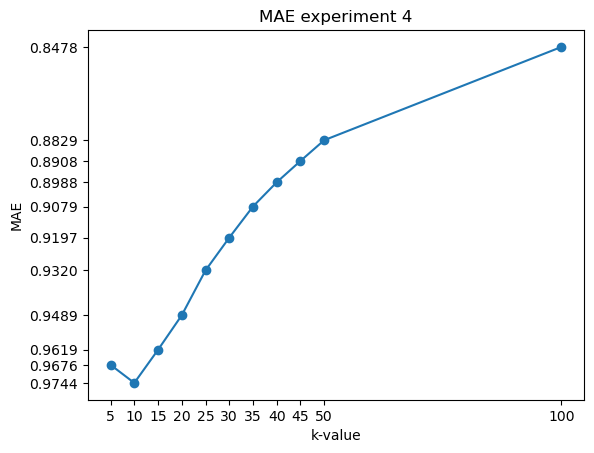

In [240]:
import matplotlib.pyplot as plt
keys = list(results_mae_user_sample_1.keys())
values = list(results_mae_user_sample_1.values())

plt.plot( keys,values, marker= 'o')
plt.xlabel("k-value")
plt.ylabel("MAE")
plt.title("MAE experiment 4")
plt.gca().invert_yaxis()
plt.yticks(values)
plt.xticks(keys)

plt.show

In [139]:
precision_k5, recall_k5 = run_precision_recall_calculation(user_sample, nearest_neighbors_model, 10)

In [141]:
precision_k5

0.0782

In [142]:
recall_k5

0.030555537524588765

In [ ]:
# update model
# mae_k10 = run_mean_absolute_error_calculation(10, user_sample)

In [84]:
test_mae = calculate_mean_absolute_error("-=Yod@=-", 20, distance_matrix)
test_mae

1.0239391745226554

In [ ]:
recommend_items(distance_matrix, "Tom Vasel", 10, 
                nearest_neighbors_model)

In [116]:
test_recommended_items, test_rec_df = recommend_items(distance_matrix, "-=Yod@=-", 10, nearest_neighbors_model)
test_recommended_items

[132531,
 189932,
 192135,
 162886,
 274637,
 161936,
 270844,
 268864,
 266507,
 262712]

In [127]:
test_recommended_items, test_rec_df = recommend_items(distance_matrix, "-=Yod@=-", 10, nearest_neighbors_model)
test_recommended_items

[132531,
 189932,
 192135,
 162886,
 274637,
 161936,
 270844,
 268864,
 266507,
 262712]

In [108]:
test_recommended_items, test_rec_df = recommend_items(distance_matrix, "-=Yod@=-", 30, nearest_neighbors_model)
test_recommended_items

[192135,
 166669,
 204472,
 159675,
 229853,
 271324,
 176734,
 241451,
 193738,
 177736,
 28720,
 256960,
 274637,
 191189,
 119506,
 276025,
 251247,
 249259,
 296151,
 218417,
 9216,
 224710,
 266810,
 317985,
 189932,
 316554,
 314040,
 312484,
 224517,
 308765]

In [74]:
relevant_items

,BGGId,Rating,Rating_avg,Adjusted_Rating,Username,Name
0,2381,7.5,7.287829,0.212171,-=Yod@=-,Scattergories
1,257501,8.0,7.287829,0.712171,-=Yod@=-,KeyForge: Call of the Archons
2,11,7.0,7.287829,-0.287829,-=Yod@=-,Bohnanza
3,139030,7.5,7.287829,0.212171,-=Yod@=-,Mascarade
4,24480,7.0,7.287829,-0.287829,-=Yod@=-,The Pillars of the Earth
...,...,...,...,...,...,...
1204355,161533,8.0,7.393506,0.606494,zzzzzane,Lisboa
1204356,150,6.0,7.393506,-1.393506,zzzzzane,PitchCar
1204357,320,8.0,7.393506,0.606494,zzzzzane,Scrabble
1204358,521,10.0,7.393506,2.606494,zzzzzane,Crokinole


In [114]:
# Username
# leffe dubbel            1081
# Hessu68                 1020
# oldgoat3769967          1002
# TomVasel                 996
# Pandorzecza              953
#                         ... 
# RoN_Rancor               100
# generationX              100
# Nathan G                 100
# starvinmartian_games     100
# chsbellboy               100

#users: -Johnny-	-mIDE-	-toni-	...Hammer	
test_recommended_items_2, test_recommended_items_2_df = recommend_items(distance_matrix, "leffe dubbel", 10, nearest_neighbors_model)
test_relevant_items_2 = relevant_items["leffe dubbel"]
test_precision_2 = calculate_precision(test_recommended_items_2, test_relevant_items_2)
test_precision_2

9625
25021
188
79828
54138
39351
237182
84419
163068
91
antal true positives:  10


1.0

In [77]:
len(test_relevant_items_2)

154

In [78]:
test_recommended_items_2_df

,Predicted rating
BGGId,
9625,8.072541
25021,8.058141
188,8.018426
79828,8.002364
54138,7.998041
39351,7.946282
237182,7.941399
84419,7.912132
163068,7.892771


Nedan skriver vi funktion som visar resultat av rekomendation i form av en sorts lista baserat på recommender funktionen

Nedan här skriver vi evalueringsfunktioner av modellen och utskrift 